# Project

## Import libraries

In [2]:
!pip install geneticalgorithm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import statistics
import random
from geneticalgorithm import geneticalgorithm as ga
from google.colab import files
from scipy.ndimage import binary_dilation
from sklearn.cluster import DBSCAN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 890.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15076 sha256=cb5ae03d31c0210b96d490498047dd58bb87e86b5a68f90db65bb8765950b214
  Stored in directory: /root/.cache/pip/wheels/07/e6/86/f23164d12c3134966614102db8e7956ab359faf7ffd78703ce
Successfully built func-timeout


In [6]:
uploaded = files.upload()  # Opens file selection window

Saving sample_grid.csv to sample_grid.csv


# General functions



### Loading Map and Temperature

In [16]:
def load_map(filename='sample_grid.csv'):
    df = pd.read_csv(filename)

    # Mapping of types to numerical values
    type_to_num = {'building': 0, 'road': 1, 'green_space': 2, 'water': 3}
    num_to_type = {v: k for k, v in type_to_num.items()}
    df['type_num'] = df['type'].map(type_to_num)

    # Creating pivot tables for types and temperatures
    type_pivot = df.pivot(index='y', columns='x', values='type_num')
    temp_pivot = df.pivot(index='y', columns='x', values='temp_fac')

    # Sort rows and columns by alignment
    type_pivot = type_pivot.sort_index(ascending=True).sort_index(axis=1, ascending=True)
    temp_pivot = temp_pivot.sort_index(ascending=True).sort_index(axis=1, ascending=True)

    # Conversion to NumPy array for quick access
    type_matrix = type_pivot.values
    temp_matrix = temp_pivot.values

    return type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type

### Landuse plot

In [17]:
def generate_terrain_map(type_pivot, ax=None, show=True):
    """
    Plots the terrain type map, returning the figure and axis for further modifications.

    Parameters:
    - type_pivot: 2D numpy array representing terrain types
    - ax: Matplotlib axis object (optional), allows overlaying on an existing plot
    - show: If True, calls plt.show(). Set to False if additional layers are added.

    Returns:
    - fig, ax: Matplotlib figure and axis objects
    """

    # Define fixed terrain types
    terrain_types = {
        0: ('black', 'Building'),
        1: ('tab:gray', 'Road'),
        2: ('tab:green', 'Green Space'),
        3: ('tab:blue', 'Water')
    }

    # Create a colormap and normalization
    cmap_colors = [terrain_types[k][0] for k in range(4)]  # Ensure correct order
    cmap = mcolors.ListedColormap(cmap_colors)
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # Plot the terrain map
    im = ax.imshow(type_pivot, origin='lower', cmap=cmap, norm=norm)
    ax.set_title("Terrain Type Map")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # Generate legend dynamically
    legend_patches = [mpatches.Patch(color=terrain_types[k][0], label=terrain_types[k][1])
                       for k in range(4)]
    ax.legend(handles=legend_patches, loc='upper right')

    plt.tight_layout()

    # Show the plot if required
    if show:
        plt.show()

    return fig, ax  # Return figure and axis for further modifications


### Heatmap plot

In [18]:
def generate_heatmap(temp_matrix, vmin=None, vmax=None, ax=None, show=True):
    """
    Generates a temperature heatmap, returning the figure and axis for further modifications.

    Parameters:
    - temp_matrix: 2D numpy array of temperatures
    - vmin, vmax: Optional color scale limits
    - ax: Matplotlib axis object (optional), allows overlaying on an existing plot
    - show: If True, calls plt.show(). Set to False if additional layers are added.

    Returns:
    - fig, ax: Matplotlib figure and axis objects
    """
    mean_temp = np.mean(temp_matrix)
    max_temp = np.max(temp_matrix)

    if vmin is None:
        vmin = np.min(temp_matrix)
    if vmax is None:
        vmax = np.max(temp_matrix)

    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # Plot heatmap
    img = ax.imshow(temp_matrix, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax)
    ax.set_title("Heatmap - Temperature Condition")

    # Add colorbar if not overlaying on an existing axis
    if ax is None:
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label("Temperature")

    plt.tight_layout()

    # Show the plot if required
    if show:
        plt.show()

    return fig, ax  # Return figure and axis for further modifications

### Heat Island Plot

In [19]:
def detect_heat_islands(temp_matrix, threshold=32):
    """
    Detects heat islands and their edges in a temperature matrix.

    Returns:
        cluster_grid: 2D grid with cluster labels (-1 = no cluster)
        edges: 2D boolean grid where True indicates edge of cluster
    """
    # Get grid dimensions
    H, W = temp_matrix.shape

    # Get all coordinates
    y_coords, x_coords = np.indices((H, W))
    coords = np.column_stack((y_coords.ravel(), x_coords.ravel()))
    temps = temp_matrix.ravel()

    # Select hot regions
    hot_mask = temps >= threshold
    hot_coords = coords[hot_mask]

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=1.5, min_samples=3)
    hot_clusters = dbscan.fit_predict(hot_coords)

    # Create cluster grid
    cluster_grid = np.full((H, W), fill_value=-1)
    for (y, x), cluster_label in zip(hot_coords, hot_clusters):
        cluster_grid[y, x] = cluster_label

    # Identify cluster edges
    edges = np.zeros_like(cluster_grid, dtype=bool)
    for cluster_label in np.unique(hot_clusters[hot_clusters >= 0]):
        cluster_mask = cluster_grid == cluster_label
        dilated_mask = binary_dilation(cluster_mask, structure=np.ones((3, 3)))
        edge = dilated_mask & cluster_mask
        edges |= edge

    return cluster_grid, edges

def generate_heat_island_map(reduced_temp, temp_matrix, vmin=None, vmax=None, ax=None, show=True, threshold=32.0, original=True):
    """
    Generates a heatmap with heat island contours.

    Parameters:
    - temp_matrix: 2D numpy array of temperatures.
    - vmin, vmax: Optional color scale limits.
    - ax: Matplotlib axis object (optional), allows overlaying on an existing plot.
    - show: If True, calls plt.show(). Set to False if additional layers are added.

    Returns:
    - fig, ax: Matplotlib figure and axis objects.
    """
    if original:
      _, edges = detect_heat_islands(temp_matrix, threshold)
    else:
      _, edges = detect_heat_islands(reduced_temp, threshold)
    # Generate base heatmap
    fig, ax = generate_heatmap(reduced_temp, vmin, vmax, ax=ax, show=False)

    # Overlay temperature statistics
    avg,avg_hotspot = calculate_objective_stats(reduced_temp,temp_matrix)
    ax.text(0.02, 0.98, f"Mean: {avg:.2f}\nMeanHot: {avg_hotspot:.2f}",
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    # Overlay heat island edges
    ax.contour(edges, colors='yellow', linewidths=1.5, alpha=0.8)

    # Title and final display logic
    ax.set_title("Heat Map with Hot Region Cluster Edges")
    ax.axis('off')

    if show:
        plt.show()

    return fig, ax  # Return figure and axis for further modifications



# General solution visualization functions

### Solution calculation functions

In [20]:
def calculate_reduced_heatmap(solution,temp_matrix,tree_species):
    """
    Computes the adjusted temperature map after applying the cooling effects of placed trees.

    The function simulates the cooling using a Gaussian model.
    Each tree reduces the temperature in a radius around its location, with the cooling intensity
    determined by the species-specific decay factor and cooling effect.

    Parameters:
    - solution: List of placed trees, each represented as (row, col, species).
    - temp_matrix: 2D numpy array of initial temperatures before tree placement.
    - tree_species: Dictionary containing properties of different tree species, including:
      - "cooling": Maximum cooling effect at the tree's center.
      - "decay": Factor controlling the spread of cooling influence.

    Returns:
    - final_temp: 2D numpy array of the adjusted temperature map after applying tree cooling effects.
    """

    final_temp = np.copy(temp_matrix)
    Y, X = np.indices((H, W))
    for (row_center, col_center, candidate_type) in solution:
        sigma = 1 + (1 - tree_species[candidate_type]["decay"]) * 5
        dist2 = (Y - row_center)**2 + (X - col_center)**2
        effect = tree_species[candidate_type]['cooling'] * np.exp(-dist2 / (2 * sigma**2))
        final_temp -= effect
    return final_temp


def calculate_objective_stats(heatmap, temp_matrix, threshold=32.0):
    """
    Computes the average temperature and the mean hotspot temperature.

    Parameters:
    - heatmap: 2D numpy array of adjusted temperatures.
    - temp_matrix: 2D numpy array of initial temperatures.
    - threshold: Temperature value to define hotspots (default: 32.0°C).

    Returns:
    - avg_temp: Overall average temperature.
    - mean_hotspot_temp: Average temperature in detected heat islands.
    """

    heatislands = detect_heat_islands(temp_matrix, threshold)[1]
    avg_temp = np.mean(heatmap)
    mean_hotspot_temp = np.mean(heatmap[heatislands]) if np.any(heatislands) else avg_temp  # Avoid NaN

    return avg_temp, mean_hotspot_temp


def calculate_used_budget(solution, tree_species):
    """
    Calculates the total budget used for placing the trees.

    Parameters:
    - solution: List of tree placements [(row, col, species)].
    - tree_species: Dictionary with tree properties, including 'base_price'.

    Returns:
    - budget_used: Total cost of the placed trees.
    """

    budget_used = sum(tree_species[candidate_type]['base_price'] for (_, _, candidate_type) in solution)
    return budget_used


### Solution text output functions

In [21]:
def print_solution_elements(solution, heading='Optimized Solution'):
  print(f"\n--- {heading} ---")
  print("Number of placements:", len(solution))
  for (row, col, candidate_type) in solution:
      print(f"Type: {tree_species[candidate_type]['name']} at Position: ({row}, {col})")

### Solution visualization functions

In [22]:
def generate_solution_map(solution, temp_matrix, tree_species, vmin=None, vmax=None, use_heat_islands=False, show=True):
    """
    Visualizes the optimized temperature map with tree placements in a single plot.

    Parameters:
    - solution: List of placed trees [(row, col, species)].
    - temp_matrix: 2D numpy array of temperatures.
    - tree_species: Dictionary with tree properties.
    - vmin, vmax: Optional color scale limits.
    - use_heat_islands: If True, overlays heat island edges.
    - show: If True, calls plt.show(). Set to False to layer more elements.

    Returns:
    - fig, ax: Matplotlib figure and axis objects.
    """

    # Compute reduced heatmap & stats
    heatislands = detect_heat_islands(temp_matrix)[1]
    sol_temp = calculate_reduced_heatmap(solution, temp_matrix, tree_species)
    sol_avg, sol_hot_avg = calculate_objective_stats(sol_temp, heatislands)
    sol_budget = calculate_used_budget(solution, tree_species)

    # Use either generate_heatmap or generate_heat_island_map as base
    if use_heat_islands:
        fig, ax = generate_heat_island_map(sol_temp, temp_matrix,  vmin=vmin, vmax=vmax, show=False)
    else:
        fig, ax = generate_heatmap(sol_temp, vmin, vmax, show=False)

    ax.set_title("Optimized Temperature Map (Random Insertion)")

    # Overlay solution stats
    ax.text(0.95, 0.95, f"Mean: {sol_avg:.2f}\nHot Avg: {sol_hot_avg:.2f}\nBudget Used: {sol_budget:.2f}",
            transform=ax.transAxes, fontsize=12, color='black',
            backgroundcolor='white', ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.8))

    # Overlay tree placements
    for row, col, t in solution:
        ax.scatter(col, row, marker='^', s=60, color=tree_species[t]["color"], edgecolors='black')

    if show:
      plt.show()

    return fig, ax  # Return figure & axis for further modifications

def print_solution_histogram(solution, temp_matrix, tree_species, bins=30):
    """
    Plot histogram comparing temperature distributions before and after cooling.

    Parameters:
    - original_map: 2D array (before cooling)
    - cooled_map: 2D array (after cooling)
    - bins: number of bins for the histogram
    """
    orig_flat = temp_matrix.flatten()
    cool_flat = calculate_reduced_heatmap(solution,temp_matrix, tree_species).flatten()

    plt.figure(figsize=(10, 6))
    plt.hist(orig_flat, bins=bins, alpha=0.6, label='Original', color='red', edgecolor='black')
    plt.hist(cool_flat, bins=bins, alpha=0.6, label='Cooled', color='blue', edgecolor='black')

    plt.axvline(np.mean(orig_flat), color='red', linestyle='dashed', linewidth=1.5)
    plt.axvline(np.mean(cool_flat), color='blue', linestyle='dashed', linewidth=1.5)

    plt.title('Temperature Distribution Before and After Cooling')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Solution comparison

In [23]:
def plot_comparison_original_heatmap(solution, temp_matrix, tree_species, vmin=None, vmax=None, use_heat_islands=False, show=True):
    """
    Compares the initial temperature map vs. the optimized one side by side.

    Parameters:
    - solution: List of placed trees [(row, col, species)].
    - temp_matrix: 2D numpy array of initial temperatures.
    - tree_species: Dictionary with tree properties.
    - vmin, vmax: Optional color scale limits.
    - use_heat_islands: If True, overlays heat island edges on both maps.
    - show: If True, calls plt.show(). Set to False to modify further.

    Returns:
    - fig, axs: Matplotlib figure and axes objects.
    """

    # Compute optimized temperature map
    heatislands = detect_heat_islands(temp_matrix)[1]
    sol_temp = calculate_reduced_heatmap(solution, temp_matrix, tree_species)

    # Set consistent color scale
    if vmin is None:
        vmin = min(np.min(temp_matrix), np.min(sol_temp))
    if vmax is None:
        vmax = max(np.max(temp_matrix), np.max(sol_temp))

    # Create figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot initial heatmap
    if use_heat_islands:
        generate_heat_island_map(temp_matrix, temp_matrix, vmin=vmin, vmax=vmax, show=False, ax=axs[0])
    else:
        generate_heatmap(temp_matrix, vmin, vmax, show=False, ax=axs[0])
    axs[0].set_title("Initial Temperature Map")

    # Plot optimized heatmap
    if use_heat_islands:
        generate_heat_island_map(sol_temp, temp_matrix, vmin=vmin, vmax=vmax, show=False, ax=axs[1])
    else:
        generate_heatmap(sol_temp, vmin, vmax, show=False, ax=axs[1])
    axs[1].set_title("Optimized Temperature Map")

    # Adjust layout
    plt.tight_layout()

    if show:
        plt.show()

    return fig, axs

def plot_comparison_solution_heatmap(solution1, solution2, temp_matrix, tree_species, vmin=None, vmax=None, use_heat_islands=False, show=True):
    """
    Compares two different solutions side by side.

    Parameters:
    - solution1: First list of placed trees [(row, col, species)].
    - solution2: Second list of placed trees [(row, col, species)].
    - temp_matrix: 2D numpy array of initial temperatures.
    - tree_species: Dictionary with tree properties.
    - vmin, vmax: Optional color scale limits.
    - use_heat_islands: If True, overlays heat island edges on both maps.
    - show: If True, calls plt.show(). Set to False to modify further.

    Returns:
    - fig, axs: Matplotlib figure and axes objects.
    """
    # Compute optimized temperature map
    heatislands = detect_heat_islands(temp_matrix)[1]
    sol_temp1 = calculate_reduced_heatmap(solution1, temp_matrix, tree_species)
    sol_temp2 = calculate_reduced_heatmap(solution2, temp_matrix, tree_species)

    # Set consistent color scale
    if vmin is None:
        vmin = min(np.min(sol_temp2), np.min(sol_temp1))
    if vmax is None:
        vmax = max(np.max(sol_temp2), np.max(sol_temp1))

    # Create figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot solution maps
    if use_heat_islands:
        generate_heat_island_map(sol_temp1, temp_matrix, vmin=vmin, vmax=vmax, show=False, ax=axs[0])
        generate_heat_island_map(sol_temp2, temp_matrix, vmin=vmin, vmax=vmax, show=False, ax=axs[1])
    else:
        generate_heatmap(sol_temp1, vmin, vmax, show=False, ax=axs[0])
        generate_heatmap(sol_temp2, vmin, vmax, show=False, ax=axs[1])
    axs[0].set_title("Optimized Temperature Map 1")
    axs[1].set_title("Optimized Temperature Map 2")

    # Adjust layout
    plt.tight_layout()

    if show:
        plt.show()

    return fig, axs

def plot_solution_histogram_comparison(solution1, solution2, temp_matrix, tree_species, bins=30):
    """
    Plot histogram comparing temperature distributions for two solutions (before and after cooling).

    Parameters:
    - solution1: First solution (list of tree placements [(row, col, species)]).
    - solution2: Second solution (list of tree placements [(row, col, species)]).
    - temp_matrix: 2D array of original temperatures.
    - tree_species: Dictionary with tree species properties.
    - bins: Number of bins for the histogram.
    """
    # Calculate cooled maps for both solutions
    cool_flat_1 = calculate_reduced_heatmap(solution1, temp_matrix, tree_species).flatten()
    cool_flat_2 = calculate_reduced_heatmap(solution2, temp_matrix, tree_species).flatten()

    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(cool_flat_1, bins=bins, alpha=0.6, label='Solution 1', color='blue', edgecolor='black')
    plt.hist(cool_flat_2, bins=bins, alpha=0.6, label='Solution 2', color='green', edgecolor='black')

    # Add mean lines
    plt.axvline(np.mean(cool_flat_1), color='blue', linestyle='dashed', linewidth=1.5)
    plt.axvline(np.mean(cool_flat_2), color='green', linestyle='dashed', linewidth=1.5)

    # Add labels and title
    plt.title('Temperature Distribution Comparison for Two Solutions')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Problem parameter initialization

### Load and visualize map wiht heat islands

In [24]:
# Loading the map
type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type = load_map('sample_grid.csv')
H, W = type_matrix.shape

# Derive mininmal and maximal Temperature for scales in plots
vmin,vmax = np.min(temp_matrix),np.max(temp_matrix)

# Derive heat islands
heatislands = detect_heat_islands(temp_matrix)[1]

avg,avg_hotspot = calculate_objective_stats(temp_matrix,temp_matrix)

print(f'Average overall temperature is: {round(avg, 2)}')
print(f'Average hotspot temperature is: {round(avg_hotspot, 2)}')

Average overall temperature is: 29.85
Average hotspot temperature is: 32.96


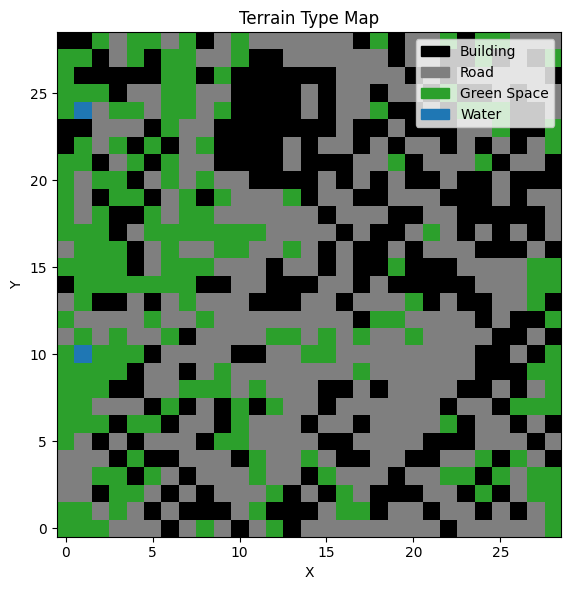

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Terrain Type Map'}, xlabel='X', ylabel='Y'>)

In [25]:
generate_terrain_map(type_pivot,show=True)

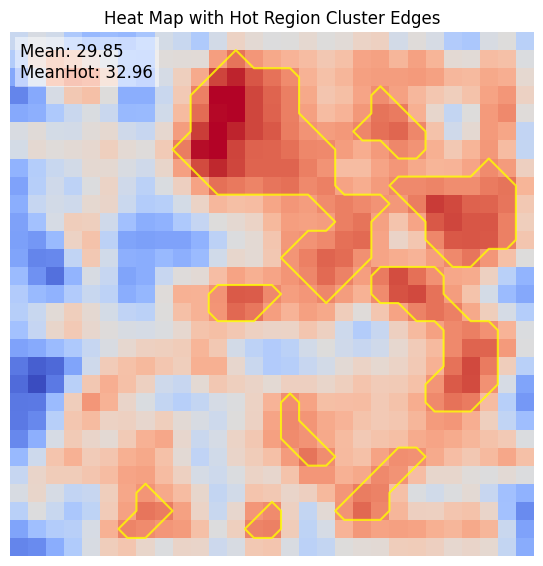

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Heat Map with Hot Region Cluster Edges'}>)

In [26]:
generate_heat_island_map(temp_matrix, temp_matrix, threshold=32, show=True)

### Parameter description

In [90]:
# Define parameters for optimization, mainly the tree species dictinary
num_candidates = 50
tree_species = {
    0: {"base_price": 50, "cooling": 0.8, "decay": 0.55,"name":"tree_1","color":"green"},
    1: {"base_price": 70, "cooling": 0.62, "decay": 0.60,"name":"tree_2","color":"orange"},
    2: {"base_price": 90, "cooling": 0.73, "decay": 0.50,"name":"tree_3","color":"purple"},
    3: {"base_price": 110, "cooling": 0.9, "decay": 0.12,"name":"tree_4","color":"cyan"},
}

# cost factor for trees placed on roads
cost_factor = 1.5

budget_max = 1500

w_mean = 0.05   # Weight for average temperature
w_max  = 0.95   # Weight for maximum temperature (hot spot)

## Objective Function definition

In [28]:
def objective(candidates):
    """
    Evaluates a multi-criteria objective function to optimize cooling measures
    in an urban heat island scenario. It considers temperature reduction, cost,
    and placement constraints.

    Parameters:
    - candidates: List of tuples [(row, col, type)] where:
        - row, col: Position on the grid.
        - type: index to tree species dictionary

    Penalties:
    - Placement outside the grid.
    - Trees placed on buildings.
    - Budget overuse.

    Reward:
    - Small reward for higher budget utilization (encourages planting more trees).

    Returns:
    - objective_value: Weighted combination of:
        - Mean temperature after cooling.
        - Mean hotspot temperature after cooling.
        - Budget penalties and rewards.
    """
    penalty = 0
    total_cost = 0
    global cost_factor

    for (row,col,candidate_type) in candidates:
        # Check: valid position within the grid
        if row < 0 or row >= H or col < 0 or col >= W:
            penalty += 1e6
            continue

        if type_matrix[row, col] == type_to_num['building']:
            penalty += 1e6
            continue
        cost_factor = cost_factor if type_matrix[row, col] == 1 else 1.0
        total_cost += tree_species[candidate_type]['base_price'] * cost_factor

    # Penalty if the total cost exceeds the budget
    if total_cost > budget_max:
        penalty += 1e6 * (total_cost - budget_max)

    # Applying the cooling effect using a Gaussian model
    final_temp = calculate_reduced_heatmap(candidates,temp_matrix,tree_species)

    # Calculation of the two criteria: average temperature and mean hotspot temperature
    avg_temp, mean_hotspot_temp = calculate_objective_stats(final_temp,temp_matrix)

    # Reward for using more budget / planting more trees
    reward = -0.001 * total_cost - 0.01 * len(candidates)

    # Multi-criteria objective function: weighted combination
    objective_value = w_mean * avg_temp + w_max * mean_hotspot_temp + penalty + reward
    return objective_value

# Random Generation

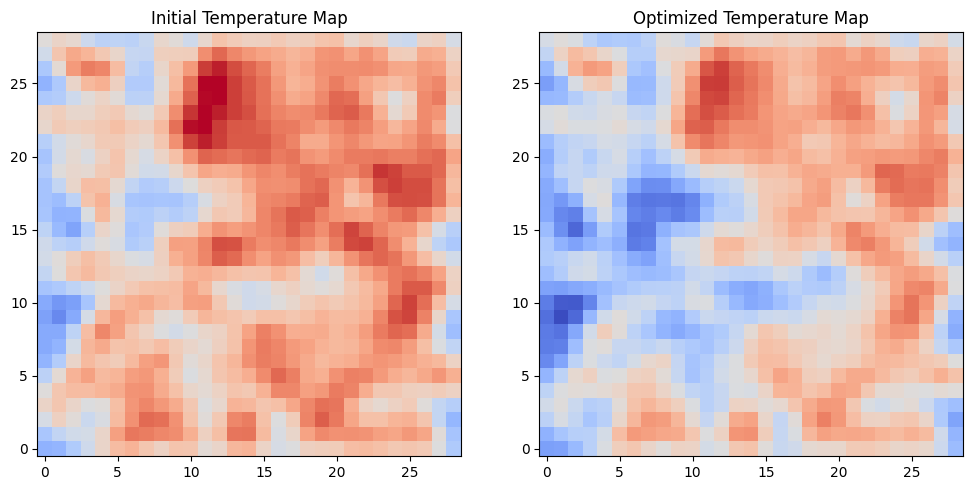

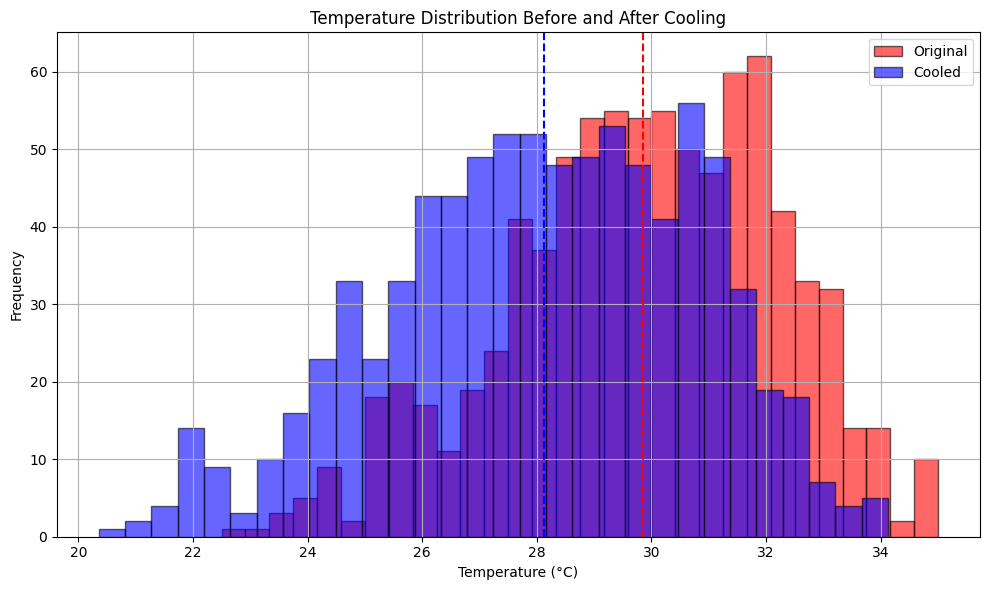

In [71]:
def random_insertion(type_matrix, budget_max, cost_factor=1.5):
    """
    Randomly insert candidates (trees and fountains) on the grid.
    The restrictions are:
      - Trees cannot be placed on cells where a building stands
      - Trees cannot be placed on top of each other (used cells)
      - Total cost must not exceed budget_max.
    Returns:
      placed_elements: List of tuples (row, col, candidate_type)
    """
    H, W = type_matrix.shape
    placed_elements = []  # List of (row, col, candidate_type)
    total_cost = 0

    # Calculate the minimum candidate cost (used to check if further placements are possible)
    min_tree_cost = min(tree_species[t]['base_price'] for t in tree_species)

    used_cells = set()
    max_iterations = H * W * 10  # Avoid infinite loops
    iterations = 0

    while total_cost + min_tree_cost <= budget_max and iterations < max_iterations:
        iterations += 1
        # Randomly choose a cell
        row = random.randint(0, H-1)
        col = random.randint(0, W-1)

        # check if cell is not a building
        if type_matrix[row, col] == type_to_num['building'] or (row, col) in used_cells:
            continue

        # randomly choose a tree
        candidate_type = random.choice(range(len(tree_species)))
        cost_factor = cost_factor if type_matrix[row, col] == 1 else 1.0
        cost = tree_species[candidate_type]['base_price']

        # Check if placing this candidate would exceed the budget
        if total_cost + cost > budget_max:
            continue


        # All restrictions passed: add candidate
        placed_elements.append((row, col, candidate_type))
        used_cells.add((row, col))
        total_cost += cost

    return placed_elements

# Run random insertion
random_solution = random_insertion(type_matrix, budget_max)

plot_comparison_original_heatmap(random_solution,temp_matrix,tree_species)
print_solution_histogram(random_solution,temp_matrix,tree_species)

# Genetic algorithms

### GA Parameter

In [30]:
# Each candidate has 4 variables: row, col, active, type
var_bound = []
for _ in range(num_candidates):
    var_bound.append([0, H-1])  # row
    var_bound.append([0, W-1])  # col
    var_bound.append([0, 1])    # active
    var_bound.append([0, 2])    # type
var_bound = np.array(var_bound)

# GA Parameters
params = {
    'max_num_iteration': 200,
    'population_size': 500,
    'mutation_probability': 0.2,
    'elit_ratio': 0.05,
    'crossover_probability': 0.7,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 50
}

# define decoding and objective function fitted to the solution vector of GA
def decode_ga_solution(ga_solution):
    """
    Decodes a genetic algorithm (GA) solution into a list of candidate tree placements.

    Parameters:
    - ga_solution: A 1D numpy array or list representing the GA solution. The solution is structured as follows:
      [row1, col1, active1, type1, row2, col2, active2, type2, ..., rowN, colN, activeN, typeN]
      where:
        - (row, col) are the coordinates of the candidate placement.
        - active indicates whether the candidate is active (1) or inactive (0).
        - type represents the tree type (0: "powerful" tree, 1: "economical" tree, 2: fountain).

    Returns:
    - candidates: A list of tuples representing valid active candidates in the format (row, col, type).
      Only active candidates are added to the list, and type is limited to values 0, 1, or 2.
    """

    candidates = []
    for i in range(num_candidates):
        if int(round(ga_solution[4*i+2])) >= 1:
          row = int(round(ga_solution[4*i]))
          col = int(round(ga_solution[4*i+1]))
          candidate_type = int(round(ga_solution[4*i+3]))
          candidate_type = max(0, min(2, candidate_type))  # Force candidate_type in [0,2]
          candidates.append((row, col, candidate_type))

    return candidates

def objective_ga(ga_solution):
    """
    Computes the objective value for a genetic algorithm (GA) solution by decoding it
    and passing it to the `objective` function.

    Parameters:
    - solution: A 1D numpy array or list representing the GA solution, to be decoded.

    Returns:
    - objective_value: The calculated objective value for the given solution based on the `objective` function.
    """
    return objective(decode_ga_solution(ga_solution))

### Single-Run

 The best solution found:
 [26. 26.  0.  2. 14. 13.  0.  0.  1.  4.  1.  0. 27. 20.  0.  2.  5. 10.
  0.  1. 20. 11.  0.  0. 22.  5.  1.  1.  2.  3.  0.  2. 12. 27.  0.  0.
  1. 26.  0.  1. 15.  2.  0.  0.  6. 22.  0.  0. 10.  7.  0.  0. 15. 14.
  1.  0. 21. 10.  0.  0. 25. 20.  1.  0. 26.  7.  1.  2. 11. 13.  1.  0.
 16.  5.  1.  2. 27. 24.  0.  0.  9. 14.  0.  1.  7. 14.  0.  2.  9.  0.
  0.  2. 11.  8.  0.  2.  5. 11.  0.  1.  0.  3.  0.  2. 20. 24.  0.  1.
  8. 12.  0.  0.  6.  2.  1.  2. 11. 20.  0.  0.  8. 19.  0.  2. 12. 28.
  1.  0. 17. 17.  1.  2.  7.  9.  0.  1. 26.  0.  0.  0. 12. 14.  0.  2.
 21. 27.  0.  2. 21. 21.  1.  0. 22. 11.  0.  1. 25. 14.  1.  2. 12. 28.
  1.  0. 22. 28.  0.  1. 16. 12.  0.  2. 14. 15.  1.  1. 16. 12.  1.  0.
 16. 18.  0.  0. 13. 10.  0.  2. 17.  8.  0.  0. 19. 10.  1.  0. 24.  9.
  0.  0.]

 Objective function:
 29.289577783310467


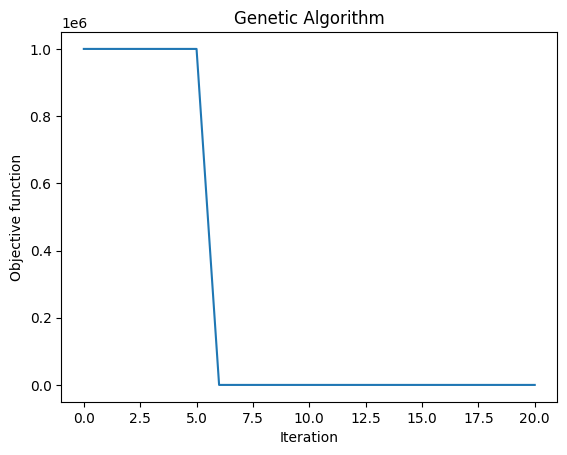


--- Single Run Result (50/50 Weighting) ---
Best solution found: [26. 26.  0.  2. 14. 13.  0.  0.  1.  4.  1.  0. 27. 20.  0.  2.  5. 10.
  0.  1. 20. 11.  0.  0. 22.  5.  1.  1.  2.  3.  0.  2. 12. 27.  0.  0.
  1. 26.  0.  1. 15.  2.  0.  0.  6. 22.  0.  0. 10.  7.  0.  0. 15. 14.
  1.  0. 21. 10.  0.  0. 25. 20.  1.  0. 26.  7.  1.  2. 11. 13.  1.  0.
 16.  5.  1.  2. 27. 24.  0.  0.  9. 14.  0.  1.  7. 14.  0.  2.  9.  0.
  0.  2. 11.  8.  0.  2.  5. 11.  0.  1.  0.  3.  0.  2. 20. 24.  0.  1.
  8. 12.  0.  0.  6.  2.  1.  2. 11. 20.  0.  0.  8. 19.  0.  2. 12. 28.
  1.  0. 17. 17.  1.  2.  7.  9.  0.  1. 26.  0.  0.  0. 12. 14.  0.  2.
 21. 27.  0.  2. 21. 21.  1.  0. 22. 11.  0.  1. 25. 14.  1.  2. 12. 28.
  1.  0. 22. 28.  0.  1. 16. 12.  0.  2. 14. 15.  1.  1. 16. 12.  1.  0.
 16. 18.  0.  0. 13. 10.  0.  2. 17.  8.  0.  0. 19. 10.  1.  0. 24.  9.
  0.  0.]

--- Single Run Result (50/50 Weighting) ---
Number of placements: 16
Type: tree_1 at Position: (1, 4)
Type: tree_2 at Po

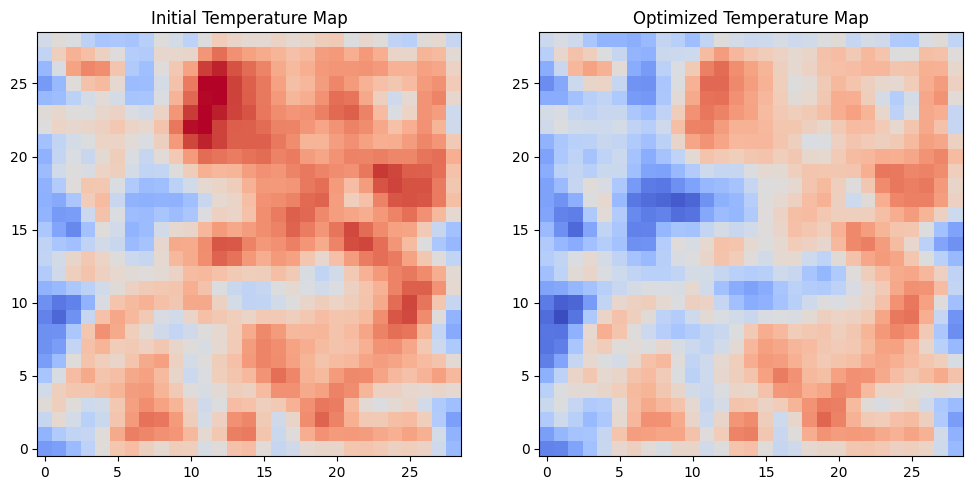

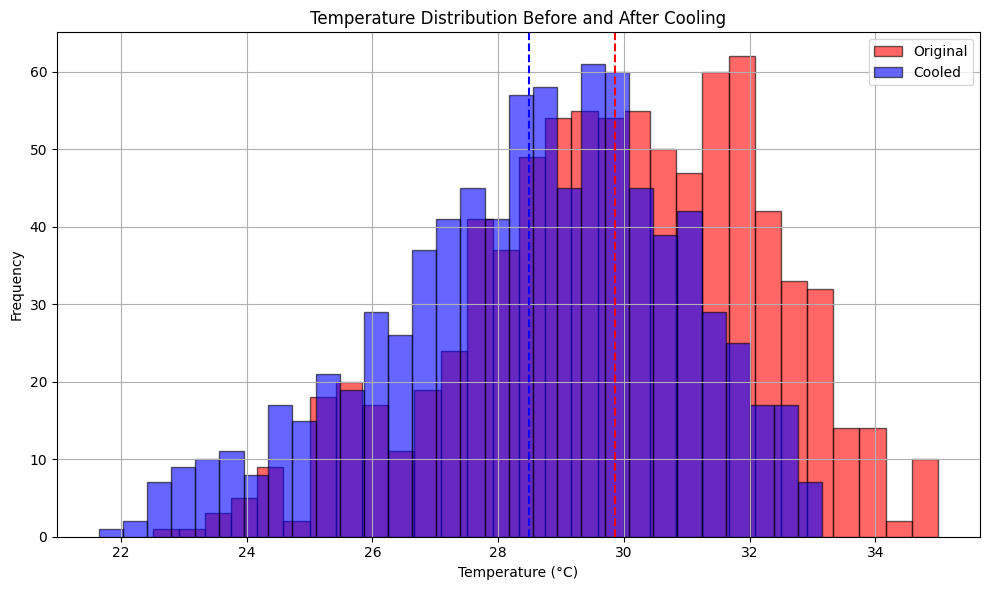

In [31]:
# ---------------------------
# Settings and 50/50 Run (already executed)
# ---------------------------
# Execute a single run (modify 'objective_hotspots' if necessary)
model = ga(function=objective_ga,
           dimension=4 * num_candidates,
           variable_type='int',
           variable_boundaries=var_bound,
           algorithm_parameters=params)

model.run()
best_sol = model.output_dict['variable']
print("\n--- Single Run Result (50/50 Weighting) ---")
print("Best solution found:", best_sol)

ga_solution = decode_ga_solution(best_sol)

print_solution_elements(ga_solution,heading='Single Run Result (50/50 Weighting)')
print("Total cost:", calculate_used_budget(ga_solution,tree_species))

plot_comparison_original_heatmap(ga_solution,temp_matrix, tree_species)
print_solution_histogram(ga_solution,temp_matrix,tree_species)

### Comparison to Random run

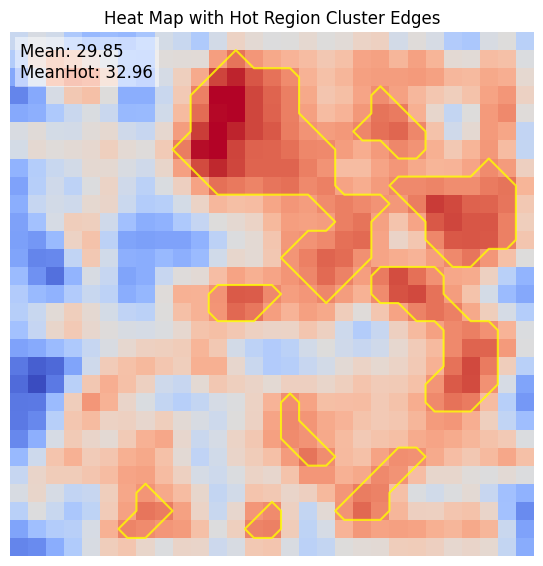

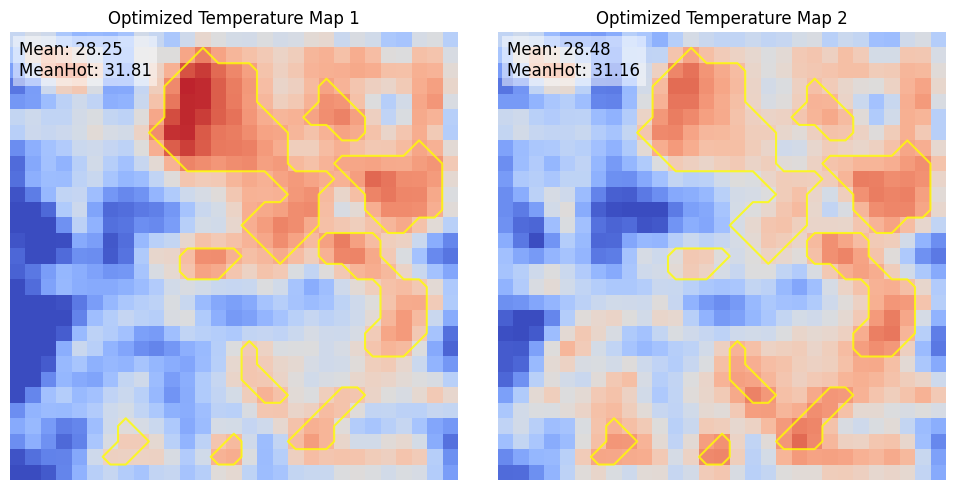

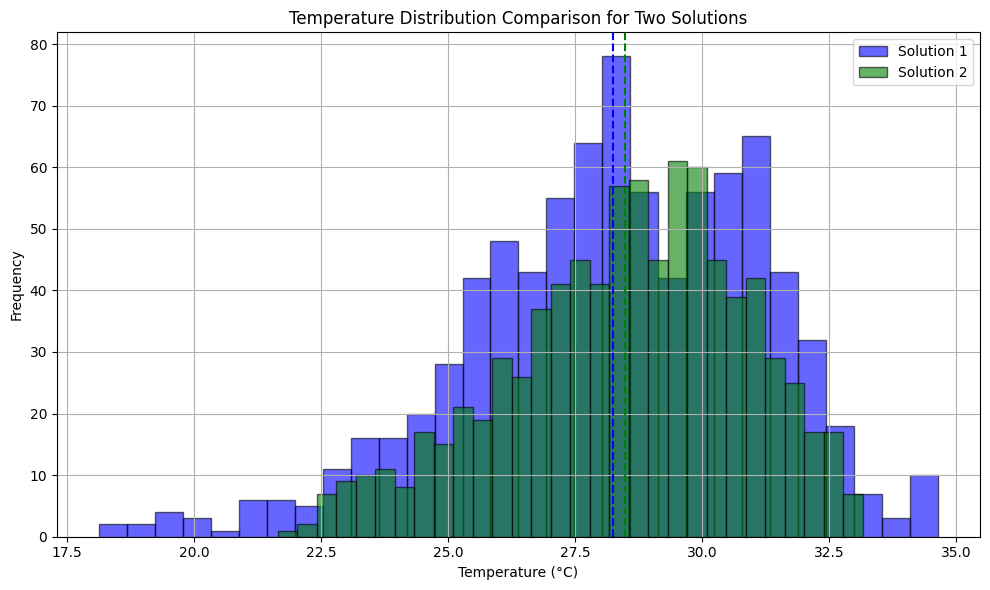

In [32]:
generate_heat_island_map(temp_matrix, temp_matrix, vmin=vmin,vmax=vmax,show=True)
plot_comparison_solution_heatmap(random_solution,ga_solution,temp_matrix,
                                 tree_species,use_heat_islands=True, vmin=vmin,vmax=vmax,show=True)
plot_solution_histogram_comparison(random_solution, ga_solution, temp_matrix, tree_species)

# ACO

### Update pheromones


In [33]:
# -------------------------------------------------
# Update pheromone and probabilistic selection
# -------------------------------------------------
def update_pos_pheromone(best_solution, pheromone,
                     evaporation_rate=0.05, reinforcement=0.3):
    """Update pheromone levels with evaporation and reinforcement."""
    pheromone *= (1 - evaporation_rate)
    for (row, col, candidate_type) in best_solution:
        pheromone[row, col] += reinforcement

    return pheromone

def update_cand_pheromone(best_solution, candidate_pheromone,
                     evaporation_rate=0.05, reinforcement=0.01):
    """Update pheromone levels with evaporation and reinforcement."""
    candidate_pheromone *= (1 - evaporation_rate)
    for (row, col, candidate_type) in best_solution:
        candidate_pheromone[candidate_type] += reinforcement

    return candidate_pheromone

### Probabilistic Selection

In [34]:
def probabilistic_selection(type_matrix, pheromone, candidate_pheromone, budget_remaining, cost_factor):
    """
    Select a cell and candidate type based on pheromone levels and cost constraints.
    Candidate types:
      0: Powerful tree
      1: Economical tree
      2: Fountain (only allowed on green_space)
    Trees cannot be placed on a building.
    """
    feasible_choices = []
    H, W = type_matrix.shape
    for row in range(H):
        for col in range(W):
            if type_matrix[row, col] == type_to_num['building']:
                continue
            cost_factor = cost_factor if type_matrix[row, col] == 1 else 1.0
            # Check each candidate type for the cell
            for candidate_type in range(len(tree_species)):
                cost = tree_species[candidate_type]['base_price']*cost_factor
                if cost <= budget_remaining:
                    # Use pheromone level and cooling effect to compute a probability weight.
                    probability = pheromone[row, col] * candidate_pheromone[candidate_type]
                    feasible_choices.append((candidate_type, (row, col), probability))
    if not feasible_choices:
        return None, None
    candidate_types, indices, probabilities = zip(*feasible_choices)
    chosen_idx = random.choices(range(len(feasible_choices)), weights=probabilities, k=1)[0]
    return candidate_types[chosen_idx], indices[chosen_idx]


### ACO parameter

In [92]:
# -------------------------------------------------
# Ant Colony Optimization (ACO)
# -------------------------------------------------
def ant_colony_optimization(type_matrix, temp_matrix, tree_species,
                            iterations=200, num_ants=10,
                            alpha=1.0, beta=1.0, cost_factor=1.5,
                            evaporation_rate_pos=0.4, reinforcement_pos=1,
                            evaporation_rate_cand=0.2,reinforcement_cand=0.1,use_cand_pheromone=False):
    """
    Ant Colony Optimization for tree and fountain placement with grid-based constraints.

    The solution is evaluated using the same objective as in the GA:
      objective_value = w_mean * avg_temp + w_max * max_temp
    (Lower objective values are better, so we set quality = -objective_value.)
    """

    # Determine the minimum cost among all candidate types.
    min_candidate_cost = min(tree_species[t]['base_price'] for t in tree_species)

    H, W = type_matrix.shape
    pheromone = np.ones((H, W))
    candidate_pheromone = np.ones(len(tree_species))
    best_solution = []
    best_quality = float('inf')

    for _ in range(iterations):
        for _ in range(num_ants):
            solution = []
            budget_remaining = budget_max
            used_cells = set()
            while budget_remaining >= min_candidate_cost:
                candidate_type, pos = probabilistic_selection(type_matrix, pheromone, candidate_pheromone, budget_remaining, cost_factor)
                if candidate_type is None or pos in used_cells:
                    break
                row, col = pos
                cost = tree_species[candidate_type]['base_price']
                cost_factor = cost_factor if type_matrix[row, col] == 1 else 1.0
                cost *= cost_factor
                if budget_remaining >= cost:
                    solution.append((row, col, candidate_type))
                    used_cells.add(pos)
                    budget_remaining -= cost

            objective_value = objective(solution)
            if objective_value < best_quality:
                best_solution = solution
                best_quality = objective_value

        pheromone = update_pos_pheromone(best_solution, pheromone, evaporation_rate_pos,
                                                          reinforcement_pos)
        if use_cand_pheromone:
            candidate_pheromone = update_cand_pheromone(best_solution, candidate_pheromone,
                                                              evaporation_rate_cand, reinforcement_cand)

    print(candidate_pheromone)
    return best_solution


### ACO Result

In [97]:
# -------------------------------------------------
# Run ACO and display the results
# -------------------------------------------------
aco_solution = ant_colony_optimization(type_matrix, temp_matrix, tree_species,
                                       iterations=100, num_ants=10,
                                       alpha=0, beta=5.0, cost_factor=1.5,
                                       evaporation_rate_pos=0.6, reinforcement_pos=1)


aco_solution_with_cand = ant_colony_optimization(type_matrix, temp_matrix, tree_species,
                                       iterations=100, num_ants=10,
                                       alpha=0, beta=5.0, cost_factor=1.5,
                                       evaporation_rate_pos=0.6, reinforcement_pos=1,
                                       evaporation_rate_cand=0.7,reinforcement_cand=0.3,
                                       use_cand_pheromone=True)


print_solution_elements(aco_solution,heading='ACO Result')
print("Total cost:", calculate_used_budget(aco_solution,tree_species))
#print_solution_elements(aco_solution_with_cand,heading='ACO Result with Candidate Pheromones')
#print("Total cost:", calculate_used_budget(aco_solution_with_cand,tree_species))

[1. 1. 1. 1.]
[2.57142857 2.14285714 0.85714286 2.57142857]

--- ACO Result ---
Number of placements: 20
Type: tree_1 at Position: (6, 5)
Type: tree_4 at Position: (9, 3)
Type: tree_2 at Position: (0, 27)
Type: tree_4 at Position: (27, 10)
Type: tree_1 at Position: (18, 9)
Type: tree_4 at Position: (20, 22)
Type: tree_1 at Position: (21, 24)
Type: tree_4 at Position: (13, 1)
Type: tree_1 at Position: (15, 8)
Type: tree_3 at Position: (20, 19)
Type: tree_3 at Position: (2, 3)
Type: tree_1 at Position: (5, 5)
Type: tree_2 at Position: (13, 4)
Type: tree_1 at Position: (27, 14)
Type: tree_4 at Position: (11, 14)
Type: tree_1 at Position: (9, 19)
Type: tree_2 at Position: (6, 19)
Type: tree_1 at Position: (22, 20)
Type: tree_1 at Position: (18, 17)
Type: tree_4 at Position: (16, 12)
Total cost: 1500


### Comparison to Random

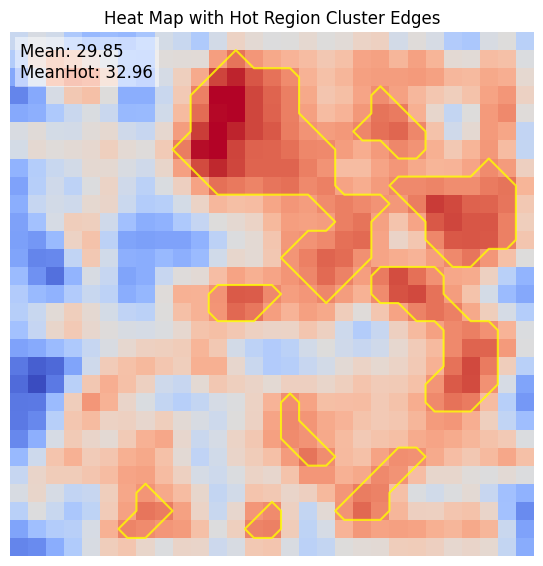

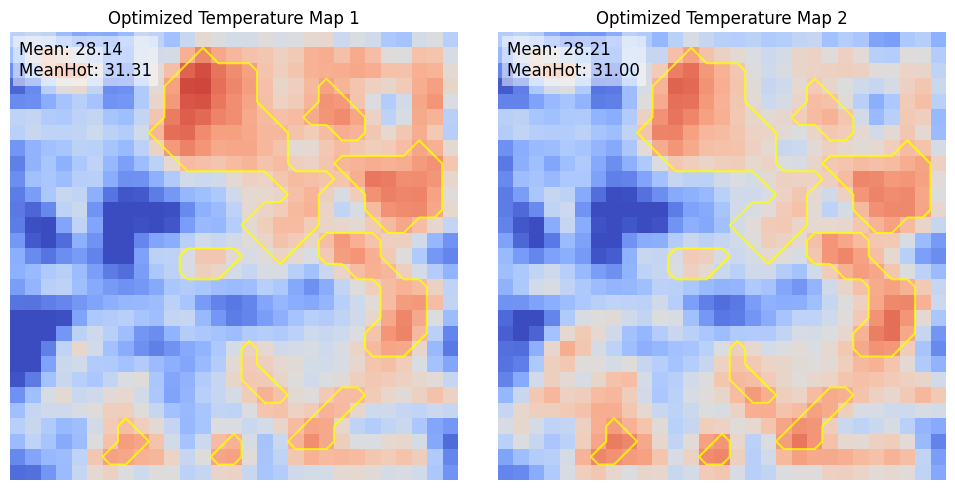

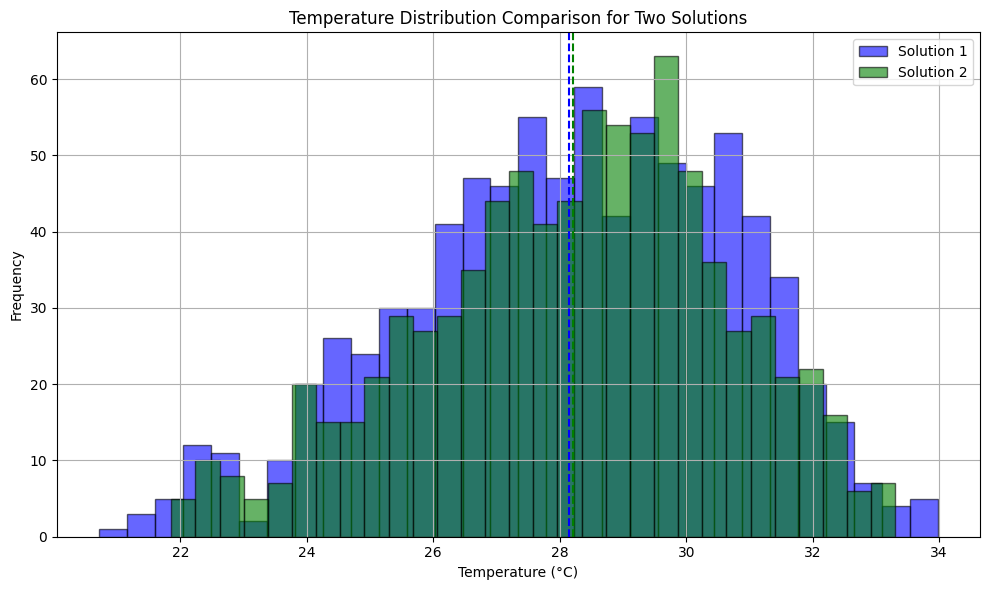

In [94]:
generate_heat_island_map(temp_matrix,  temp_matrix,vmin=vmin,vmax=vmax,show=True)
plot_comparison_solution_heatmap(random_solution,aco_solution,temp_matrix,
                                 tree_species,use_heat_islands=True, vmin=vmin,vmax=vmax,show=True)
plot_solution_histogram_comparison(random_solution, aco_solution, temp_matrix, tree_species)

# Summary

### Comparison to Random (ACO)

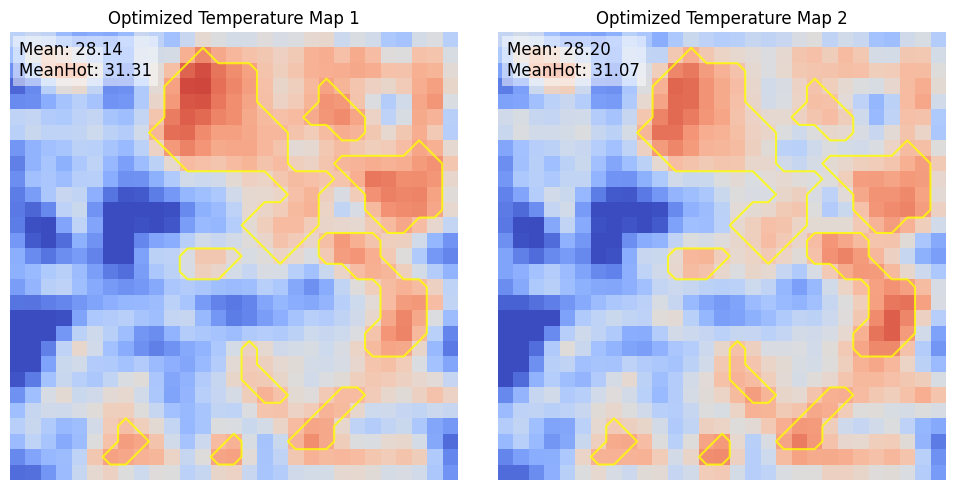

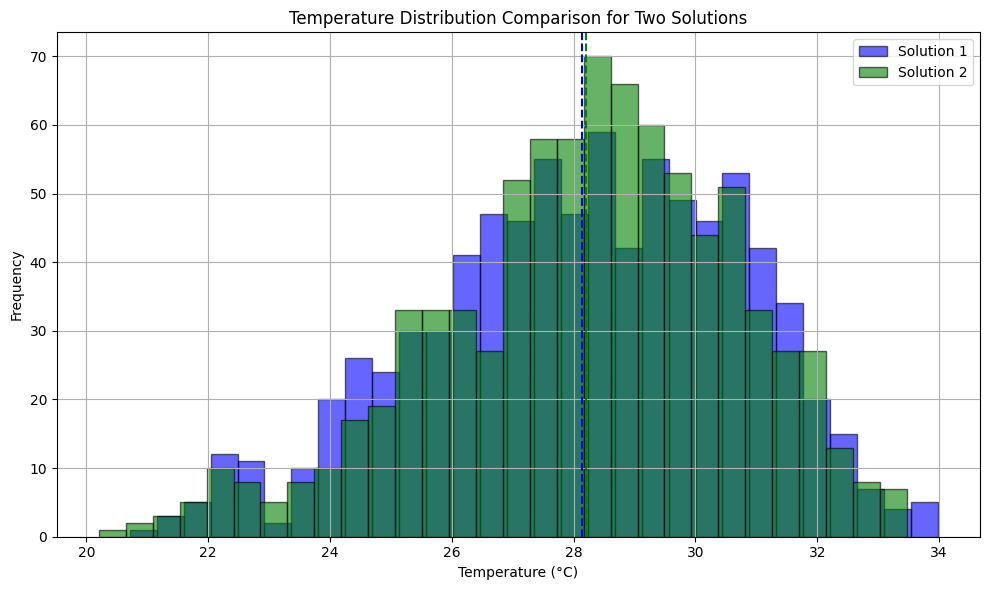

In [99]:
plot_comparison_solution_heatmap(random_solution,aco_solution,temp_matrix,
                                 tree_species,use_heat_islands=True, vmin=vmin,vmax=vmax,show=True)
plot_solution_histogram_comparison(random_solution, aco_solution, temp_matrix, tree_species)

### Comparison to Random (with candidate pheromone)

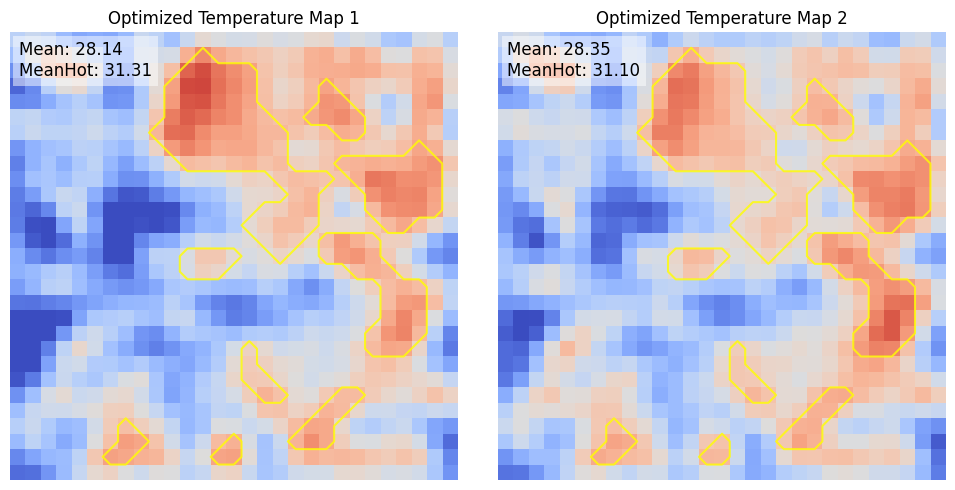

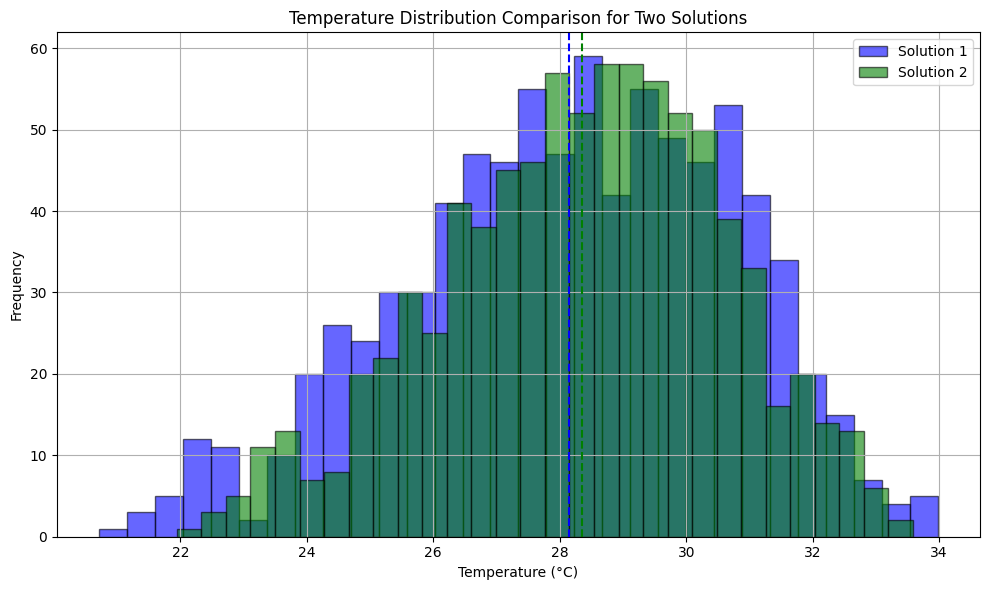

In [98]:
plot_comparison_solution_heatmap(random_solution,aco_solution_with_cand,temp_matrix,
                                 tree_species,use_heat_islands=True, vmin=vmin,vmax=vmax,show=True)
plot_solution_histogram_comparison(random_solution, aco_solution_with_cand, temp_matrix, tree_species)

### Comparison to Random (GA)

In [ ]:
plot_comparison_solution_heatmap(random_solution,ga_solution,temp_matrix,
                                 tree_species,use_heat_islands=True, vmin=vmin,vmax=vmax,show=True)
plot_solution_histogram_comparison(random_solution, ga_solution, temp_matrix, tree_species)

### Long term comparison

 The best solution found:
 [ 8.  3.  0.  1. 16. 19.  1.  1. 10. 21.  1.  0.  2.  9.  0.  2. 14. 19.
  0.  1. 13. 13.  0.  2. 12. 11.  0.  1. 28. 13.  0.  2.  8. 21.  0.  0.
 22. 20.  0.  2. 20.  7.  0.  2. 28.  5.  0.  1.  9.  9.  0.  0. 26. 16.
  1.  0. 12. 24.  0.  0. 25. 14.  1.  2. 11. 27.  0.  2.  3. 19.  0.  0.
 12.  6.  1.  1. 24. 25.  1.  0. 23. 11.  0.  1.  4. 12.  0.  0. 24.  0.
  1.  0.  9. 12.  1.  2.  8. 12.  1.  1.  6.  2.  1.  0.  5. 24.  1.  0.
 10. 21.  0.  0. 28.  9.  1.  2.  3. 20.  1.  0. 10.  1.  0.  2.  6. 24.
  0.  2.  8.  5.  0.  0.  7. 11.  0.  0. 13.  7.  0.  1. 15. 19.  1.  2.
 20. 25.  0.  1. 12. 25.  1.  0. 11.  9.  1.  1.  2.  9.  1.  0. 20.  6.
  1.  1.  4.  6.  0.  1. 22. 13.  1.  0.  9. 19.  0.  0.  9. 20.  0.  0.
 11.  3.  0.  2. 18. 24.  0.  2.  1. 18.  0.  2.  5.  1.  0.  0. 27. 26.
  1.  1.]

 Objective function:
 30.141820125174608


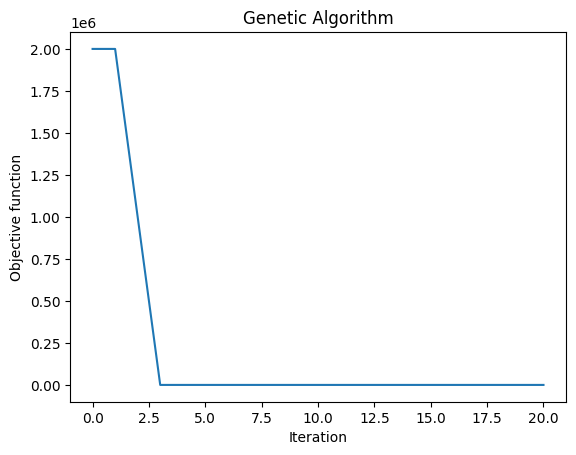

[1. 1. 1. 1.]
[0.60236821 1.19881589 0.80118411 1.        ]
 The best solution found:
 [ 1.  1.  0.  2. 26.  9.  1.  1.  9.  9.  1.  0.  3. 13.  0.  1. 17. 18.
  0.  0. 25.  4.  0.  0. 23.  3.  1.  1.  5.  5.  0.  1. 19. 28.  0.  0.
 24. 19.  0.  1. 19. 10.  1.  0. 21. 16.  0.  0. 22.  1.  1.  2. 11. 18.
  1.  0.  2. 11.  0.  0.  5.  1.  1.  0. 15.  5.  1.  0. 17. 22.  1.  1.
 11. 15.  0.  2. 18. 22.  0.  0. 23. 23.  0.  1. 19. 13.  0.  0. 24. 16.
  1.  2. 14. 24.  0.  1. 10. 21.  0.  1. 17. 22.  0.  0.  6. 14.  0.  0.
 17. 24.  1.  0. 22. 17.  0.  1. 19. 23.  0.  1. 21. 16.  0.  1. 10. 21.
  1.  1. 15. 14.  0.  1. 17. 14.  1.  1. 17.  8.  1.  1. 20. 28.  0.  0.
  1. 14.  0.  0. 17. 14.  1.  1. 27.  8.  0.  0. 17.  7.  1.  2. 14.  8.
  0.  2.  8.  4.  0.  0.  4. 12.  1.  2.  2.  8.  0.  1. 24. 17.  1.  2.
  4. 15.  0.  2. 12.  2.  0.  1. 15.  6.  1.  2. 28.  9.  0.  1. 20. 21.
  0.  2.]

 Objective function:
 30.197517681989662


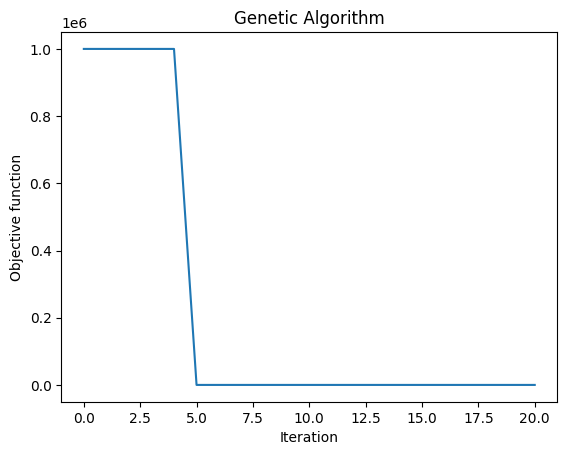

[1. 1. 1. 1.]
[0.80118411 1.39763179 0.80118411 0.80118411]
 The best solution found:
 [16. 10.  0.  1. 17. 19.  0.  0.  0. 18.  1.  1. 22. 18.  1.  0.  5.  4.
  0.  2.  5. 14.  0.  0. 19. 19.  1.  0.  1. 10.  0.  0.  9. 14.  0.  0.
 12.  9.  1.  0.  5. 11.  0.  1. 15. 17.  0.  1. 10. 21.  0.  1. 22. 15.
  0.  2. 18. 10.  1.  0. 25. 20.  1.  2. 20.  7.  1.  1. 13. 20.  0.  1.
  0.  2.  0.  2.  9. 20.  0.  0. 21.  8.  0.  0.  7. 18.  0.  1. 26. 21.
  0.  0.  8. 17.  0.  1. 11. 24.  1.  0. 23.  9.  0.  2.  3. 12.  1.  0.
 12.  2.  0.  2. 11.  4.  1.  2. 17. 22.  1.  1. 10.  6.  1.  1. 14.  4.
  1.  0. 19. 24.  0.  1. 28.  7.  0.  2.  8. 10.  0.  2.  8. 21.  0.  0.
 25. 14.  1.  2. 15. 12.  0.  0. 18. 15.  0.  2. 17. 12.  0.  1. 20. 20.
  0.  1. 20. 18.  0.  0. 11.  1.  0.  1. 15. 18.  0.  1.  3.  6.  0.  0.
  4.  2.  1.  2.  5. 12.  0.  2. 15. 27.  1.  2. 11. 17.  1.  0. 10. 17.
  0.  2.]

 Objective function:
 30.396756897175035


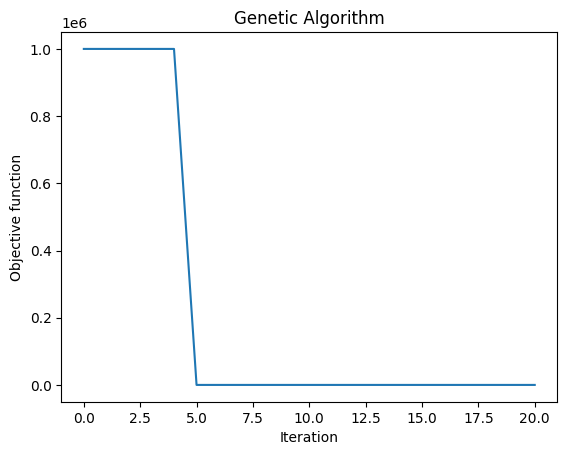

[1. 1. 1. 1.]
[1.59587695 1.00005904 0.40435024 0.99959258]
 The best solution found:
 [26. 15.  0.  2. 11. 10.  1.  1. 13. 11.  0.  2. 10. 17.  0.  2.  1.  4.
  1.  2. 22. 24.  0.  0.  6. 11.  1.  1.  5. 22.  0.  0. 21.  4.  0.  2.
  9. 19.  0.  1. 20.  9.  0.  0.  4. 24.  1.  0.  9. 26.  0.  2.  4. 10.
  0.  2. 16. 23.  1.  1. 13. 18.  0.  1.  3.  7.  0.  0. 19.  6.  1.  1.
 15.  9.  1.  0. 24.  3.  0.  1.  5.  0.  1.  1. 19. 10.  1.  0. 18. 17.
  1.  0.  3. 12.  1.  0. 14. 13.  0.  1. 21.  4.  0.  2.  8. 20.  1.  1.
 17.  7.  1.  1.  3.  0.  1.  2. 25. 20.  1.  2. 19. 20.  1.  0. 28. 12.
  1.  0. 16. 22.  0.  1. 13. 14.  0.  0. 26.  7.  0.  0. 10. 16.  1.  1.
 14.  7.  0.  2. 18.  3.  0.  0. 25.  9.  0.  2. 13. 27.  1.  2.  3. 13.
  0.  2.  9. 24.  0.  1. 18. 13.  0.  2.  1. 16.  1.  0.  4.  0.  1.  0.
  9.  4.  0.  1.  0. 10.  0.  0.  1.  3.  0.  2.  7. 15.  0.  2.  8.  2.
  1.  2.]

 Objective function:
 30.074023667874755


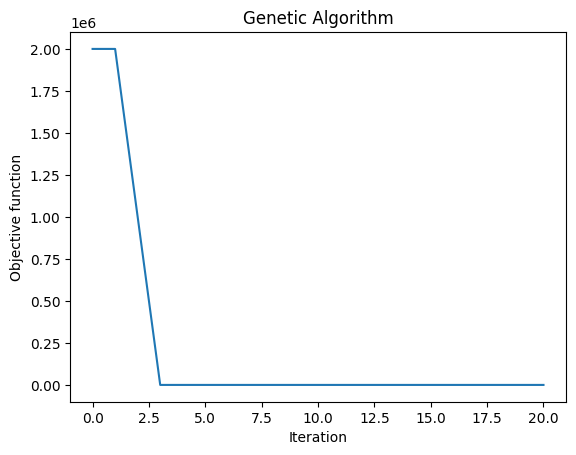

[1. 1. 1. 1.]
[0.80179613 0.6033015  1.19783101 0.99978193]
 The best solution found:
 [14.  5.  0.  0. 20. 15.  1.  0. 16.  6.  0.  1.  6.  2.  0.  1. 17.  7.
  0.  0.  3.  9.  0.  1. 14.  5.  1.  0.  4. 10.  0.  2.  2. 16.  1.  2.
 15. 22.  0.  1.  6. 20.  0.  2. 13.  0.  0.  0.  4. 20.  0.  1. 19. 20.
  0.  0. 24. 17.  1.  2.  6. 19.  1.  0.  4.  4.  1.  0. 15. 26.  1.  0.
 19. 15.  1.  1.  5.  8.  0.  2. 11. 16.  0.  1. 11.  1.  1.  2. 24. 11.
  0.  0. 19. 27.  1.  1. 24. 14.  0.  1. 16.  7.  1.  2. 16. 28.  0.  2.
  0. 21.  1.  2. 16. 27.  0.  1.  8. 16.  0.  0. 14.  6.  0.  0. 15. 15.
  0.  2. 10. 24.  0.  2. 17.  5.  0.  0. 21. 11.  0.  1. 15.  5.  0.  1.
 10. 17.  0.  1. 12. 27.  0.  1. 22. 22.  0.  0. 12. 19.  0.  1.  2.  3.
  1.  2.  7.  2.  0.  0.  6. 25.  1.  0. 11. 22.  1.  1. 20.  0.  0.  0.
 11. 17.  0.  0.  1. 17.  0.  1. 18. 17.  1.  2. 11. 12.  1.  1. 17. 26.
  1.  2.]

 Objective function:
 30.112736996983877


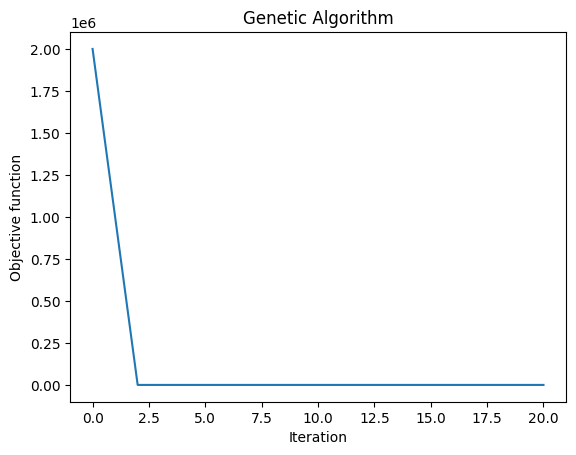

[1. 1. 1. 1.]
[0.80098713 0.60217123 0.4045372  1.59585675]


In [91]:
runs = 5
stats = [[],[],[],[]]



for _ in range(runs):
    sols = []
    sols.append(random_insertion(type_matrix, budget_max))
    model = ga(function=objective_ga,
              dimension=4 * num_candidates,
              variable_type='int',
              variable_boundaries=var_bound,
              algorithm_parameters=params)

    model.run()
    sols.append(decode_ga_solution(model.output_dict['variable']))
    sols.append(ant_colony_optimization(type_matrix, temp_matrix, tree_species,
                                       iterations=100, num_ants=10,
                                       alpha=0, beta=5.0, cost_factor=1.5,
                                       evaporation_rate_pos=0.4, reinforcement_pos=1))


    sols.append(ant_colony_optimization(type_matrix, temp_matrix, tree_species,
                                       iterations=100, num_ants=10,
                                       alpha=0, beta=5.0, cost_factor=1.5,
                                       evaporation_rate_pos=0.4, reinforcement_pos=1,
                                       use_cand_pheromone=True))
    for i in range(len(stats)):
        budget = calculate_used_budget(sols[i],tree_species)
        avg, avg_hotspot = calculate_objective_stats(calculate_reduced_heatmap(sols[i],temp_matrix,tree_species),temp_matrix)
        stats[i].append((budget,avg,avg_hotspot))


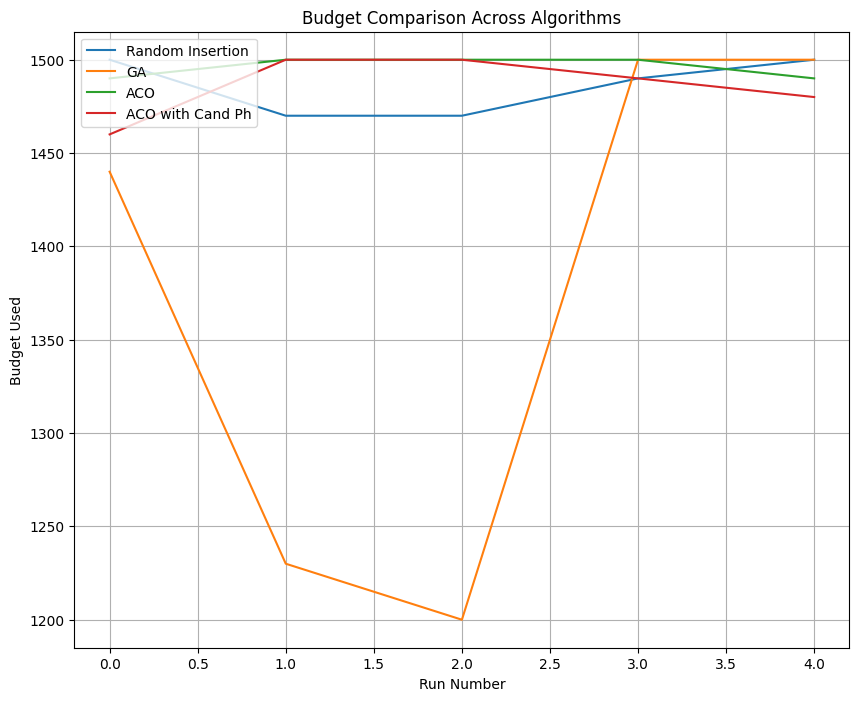

In [84]:
# Data storage for statistics of each run
algorithms = ['Random Insertion', 'GA', 'ACO', 'ACO with Cand Ph']

# Create figure and axis for each plot
fig, axs = plt.subplots(1, 1, figsize=(10, 8))

# Budget Plot
for i, algorithm in enumerate(algorithms):
    budgets = [x[0] for x in stats[i]]  # Extracting the budgets for each algorithm
    axs.plot(range(runs), budgets, label=algorithm)

axs.set_title('Budget Comparison Across Algorithms')
axs.set_xlabel('Run Number')
axs.set_ylabel('Budget Used')
axs.legend(loc='upper left')
axs.grid(True)

plt.show()


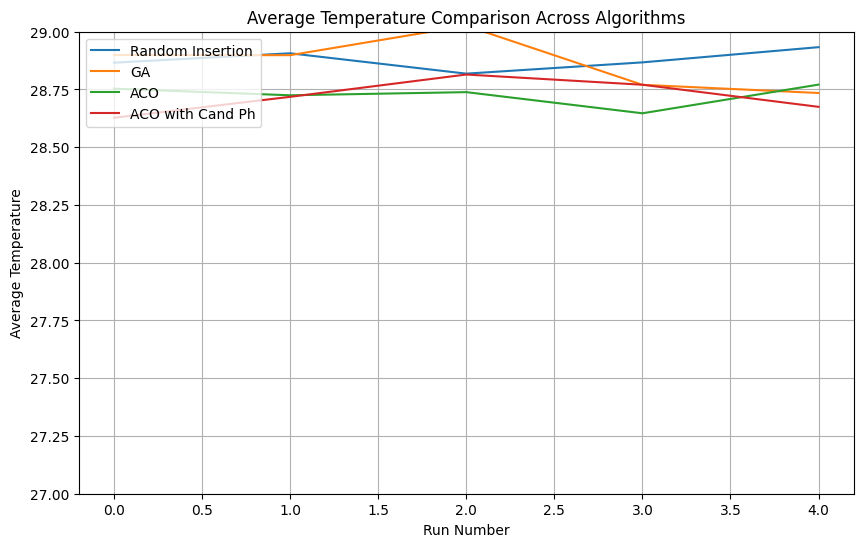

In [85]:
# Create figure and axis for each plot
fig, axs = plt.subplots(1, 1, figsize=(10, 6))

# Average Temperature Plot
for i, algorithm in enumerate(algorithms):
    avg_temps = [x[1] for x in stats[i]]  # Extracting the average temperatures for each algorithm
    axs.plot(range(runs), avg_temps, label=algorithm)

axs.set_title('Average Temperature Comparison Across Algorithms')
axs.set_xlabel('Run Number')
axs.set_ylabel('Average Temperature')
axs.legend(loc='upper left')
axs.set_ylim(27, 29)  # Ensure y-axis starts from 0
axs.grid(True)

plt.show()

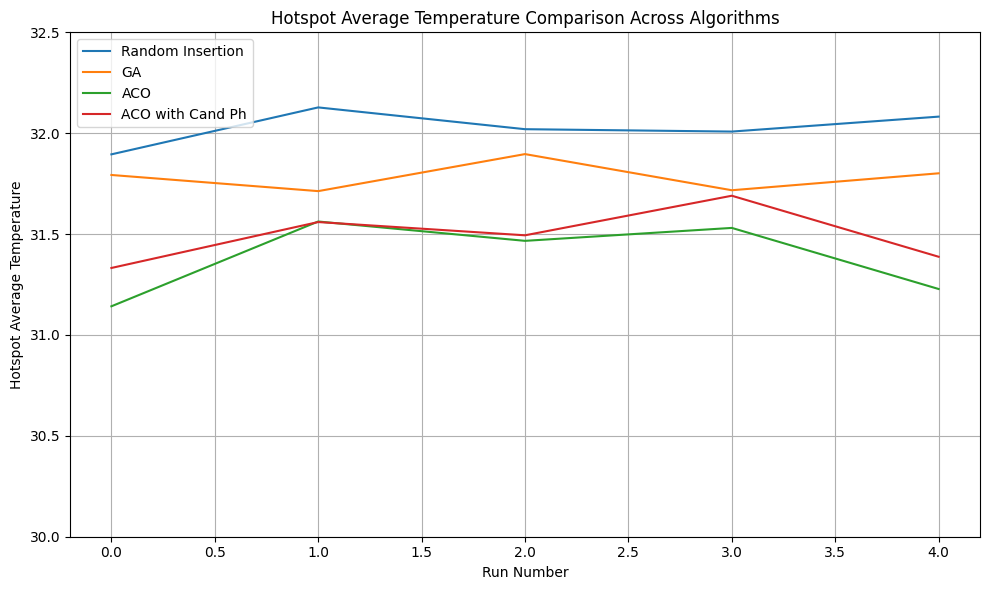

In [89]:
# Create figure and axis for each plot
fig, axs = plt.subplots(1, 1, figsize=(10, 6))

# Hotspot Average Temperature Plot
for i, algorithm in enumerate(algorithms):
    hotspot_avg_temps = [x[2] for x in stats[i]]  # Extracting the hotspot temperatures for each algorithm
    axs.plot(range(runs), hotspot_avg_temps, label=algorithm)

axs.set_title('Hotspot Average Temperature Comparison Across Algorithms')
axs.set_xlabel('Run Number')
axs.set_ylabel('Hotspot Average Temperature')
axs.legend(loc='upper left')
axs.set_ylim(30, 32.50)  # Ensure y-axis starts from 0
axs.grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()